# Gaussian Process Regression Comparison

This notebook compares three different implementations of Gaussian Process Regression:
1. `GPR`: My original implementation.
2. `GPR_efficient`: My optimized implementation.
3. `GPy`: A popular and robust third-party GP library.

The notebook will iteratively add data points and retrain each model to visualize how their predictions adapt. The output of each step is saved as a PNG image in the `gif` directory, and these images are then compiled into an animated GIF.

This version also measures and compares the execution time of each model.

### Prerequisites
1. **Create `gif` directory**: Before running, please ensure a directory named `gif` exists in the same folder as this notebook.
2. **Install libraries**: You need to install necessary libraries.

In [1]:
# Import necessary libraries
import os
import glob
import time
import imageio
import matplotlib.pyplot as plt
import numpy as np
import GPy

# Import my custom Gaussian Process implementations
from GPR import GaussianProcess
from GPR_efficient import GaussianProcessEfficient

# Ensure the output directory for images exists
if not os.path.exists('gif'):
    os.makedirs('gif')

In [2]:
# --- 1. Data Definition ---
# Define the true underlying function that we want to model.
def true_function(x):
    return np.sin(2.0 * np.pi * 0.2 * x) + np.sin(2.0 * np.pi * 0.1 * x)

# Generate a set of points for prediction and plotting.
x_predict = np.linspace(-2.0, 12.0, 150)

# --- 2. Initial Training Data ---
# Set a seed for reproducibility of random data points.
np.random.seed(10)

# Start with a single observation.
x_train = np.array([np.random.uniform(-1, 11)], dtype=np.float32)
y_train = true_function(x_train) + np.random.normal(0, 0.3, 1)

# --- 3. Initial Hyperparameters ---
# These are the starting hyperparameters for the GPR models.
# [amplitude, length_scale, constant_bias, linear_slope]
initial_theta = np.array([1.0, 1.0, 0.0, 0.0])
# The precision of the noise.
initial_beta = 1.0 / np.var(y_train)

# --- 4. Execution Time Storage ---
# Lists to store the execution time for each model at each step.
times_original = []
times_efficient = []
times_gpy = []

 /var/folders/_0/brqz32bj5bsfv8pv_1ksx2s40000gn/T/ipykernel_47099/1872046118.py:22: RuntimeWarning:divide by zero encountered in scalar divide


In [3]:
# --- 5. Iterative Learning and Comparison ---
# This loop simulates an active learning process where we add one data point at a time
# and refit the models to see how they improve.

num_observations = 50
for i in range(num_observations):
    print(f'Processing Observation: {i + 1}/{num_observations}')

    # --- Add a new data point ---
    new_x = np.array([np.random.uniform(-1, 11)], dtype=np.float32)
    new_y = true_function(new_x) + np.random.normal(0, 0.3, 1)
    x_train = np.append(x_train, new_x)
    y_train = np.append(y_train, new_y)
    
    # Reshape data for model compatibility
    x_train_reshaped = x_train.reshape(-1, 1)
    y_train_reshaped = y_train.reshape(-1, 1)
    x_predict_reshaped = x_predict.reshape(-1, 1)

    # Update noise precision based on current training data
    current_beta = 1.0 / np.var(y_train)

    # --- Model 1: GPR (Original Implementation) ---
    start_time = time.time()
    gp_original = GaussianProcess(np.copy(initial_theta), current_beta)
    gp_original.set_training_data(x_train, y_train)
    gp_original.optimize()
    mu_orig, var_orig = gp_original.prediction(x_predict)
    times_original.append(time.time() - start_time)

    # --- Model 2: GPR_efficient ---
    start_time = time.time()
    gp_efficient = GaussianProcessEfficient(np.copy(initial_theta), current_beta)
    gp_efficient.set_training_data(x_train_reshaped, y_train_reshaped)
    gp_efficient.optimize()
    mu_eff, var_eff = gp_efficient.prediction(x_predict_reshaped)
    mu_eff = mu_eff.flatten()
    times_efficient.append(time.time() - start_time)

    # --- Model 3: GPy Library ---
    start_time = time.time()
    # Define the kernel: Radial Basis Function + Linear + Bias(Constant)
    kernel_gpy = GPy.kern.RBF(input_dim=1) + GPy.kern.Linear(input_dim=1) + GPy.kern.Bias(input_dim=1)
    gpy_model = GPy.models.GPRegression(x_train_reshaped, y_train_reshaped, kernel_gpy)
    gpy_model.optimize(messages=False)
    mu_gpy, var_gpy = gpy_model.predict(x_predict_reshaped)
    mu_gpy, var_gpy = mu_gpy.flatten(), var_gpy.flatten()
    times_gpy.append(time.time() - start_time)

    # --- 6. Plotting Results ---
    plt.figure(figsize=(12, 8))
    
    # Plot true function and observations
    plt.plot(x_predict, true_function(x_predict), 'g--', label='True Function')
    plt.plot(x_train, y_train, 'ro', label='Observations')

    # Plot GPR (Original)
    plt.plot(x_predict, mu_orig, 'b-', label='GPR (Original)')
    plt.fill_between(x_predict, mu_orig - 2*np.sqrt(var_orig), mu_orig + 2*np.sqrt(var_orig), color='blue', alpha=0.15)
    
    # Plot GPR (Efficient)
    plt.plot(x_predict, mu_eff, 'orange', linestyle='-', label='GPR (Efficient)')
    plt.fill_between(x_predict, mu_eff - 2*np.sqrt(var_eff), mu_eff + 2*np.sqrt(var_eff), color='orange', alpha=0.15)

    # Plot GPy
    plt.plot(x_predict, mu_gpy, 'purple', linestyle='-', label='GPy Library')
    plt.fill_between(x_predict, mu_gpy - 2*np.sqrt(var_gpy), mu_gpy + 2*np.sqrt(var_gpy), color='purple', alpha=0.15)

    plt.title(f'GP Comparison at Observation #{i + 2}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper left')
    plt.ylim([-2.5, 2.5])
    plt.xlim([-2, 12])
    plt.grid(True)
    
    # Save frame for GIF
    plt.savefig(f'./gif/frame_{i:04d}.png')
    plt.close()

Processing Observation: 1/50
Optimize::  True
Processing Observation: 2/50
Optimize::  True
Processing Observation: 3/50
Optimize::  True
Processing Observation: 4/50
Optimize::  True
Processing Observation: 5/50
Optimize::  True
Processing Observation: 6/50
Optimize::  True
Processing Observation: 7/50
Optimize::  True
Processing Observation: 8/50
Optimize::  True
Processing Observation: 9/50
Optimize::  True
Processing Observation: 10/50
Optimize::  True
Processing Observation: 11/50
Optimize::  True
Processing Observation: 12/50
Optimize::  True
Processing Observation: 13/50
Optimize::  True
Processing Observation: 14/50
Optimize::  True
Processing Observation: 15/50
Optimize::  True
Processing Observation: 16/50
Optimize::  True
Processing Observation: 17/50
Optimize::  True
Processing Observation: 18/50
Optimize::  True
Processing Observation: 19/50
Optimize::  True
Processing Observation: 20/50
Optimize::  True
Processing Observation: 21/50
Optimize::  True
Processing Observation

In [ ]:
# --- 7. Create Animated GIF ---
print("Compiling frames into an animated GIF...")

# Find all saved frames
frames = sorted(glob.glob('./gif/frame_*.png'))

# Read images and create GIF
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave('./image/1d_gpr_comparison.gif', images, duration=0.2) # 0.2 seconds per frame

print("Successfully created '1d_gpr_comparison.gif'")

Compiling frames into an animated GIF...
Successfully created '1d_gpr_comparison.gif'


# --- 8. Execution Time Comparison ---

Total Execution Time for GPR (Original): 91.8026 seconds
Total Execution Time for GPR (Efficient): 0.8602 seconds
Total Execution Time for GPy Library: 7.3024 seconds


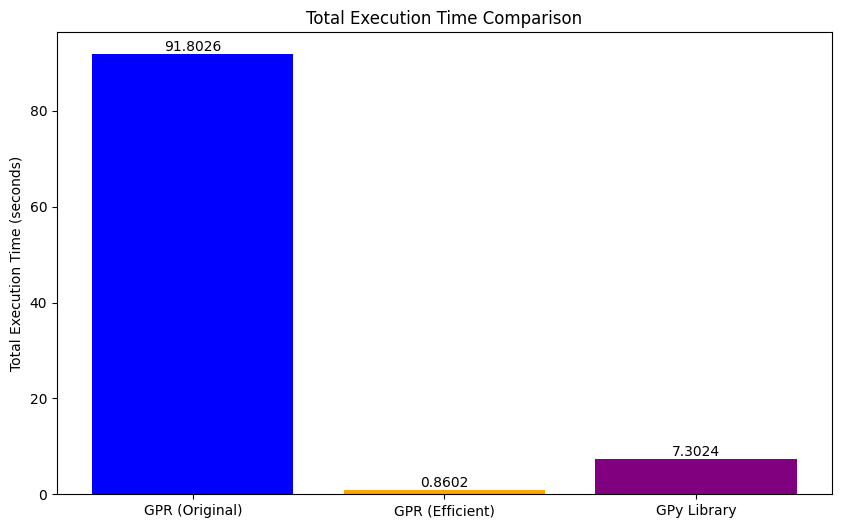

In [5]:
# Calculate total execution time for each model
total_time_original = sum(times_original)
total_time_efficient = sum(times_efficient)
total_time_gpy = sum(times_gpy)

print(f"Total Execution Time for GPR (Original): {total_time_original:.4f} seconds")
print(f"Total Execution Time for GPR (Efficient): {total_time_efficient:.4f} seconds")
print(f"Total Execution Time for GPy Library: {total_time_gpy:.4f} seconds")

# Plotting the total execution times
models = ['GPR (Original)', 'GPR (Efficient)', 'GPy Library']
times = [total_time_original, total_time_efficient, total_time_gpy]
colors = ['blue', 'orange', 'purple']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, times, color=colors)
plt.ylabel('Total Execution Time (seconds)')
plt.title('Total Execution Time Comparison')

# Add time labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()